In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,19), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,18):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData, axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7925 (199639, 19)
(191714, 19)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [5]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]

In [6]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [7]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [8]:
import seaborn as sns

In [9]:
# sns.kdeplot(x = df['dist'], y = df['satTimeDiff'], levels=20, ax = ax)
# h1 = ax.hist2d(df[xlabel],[ylabel], bins=[nx, ny], cmap=cmap, 
#                    norm=colors.LogNorm())

In [10]:
def pdfPlotTest(xlabel, ylabel, text, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_{text}_cluster.png'
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    cmap = plt.get_cmap('jet').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    levels=20, linewidths=0.5,
                    color = 'black',
                    ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel('Sat to Buoy Dist. [km]')
    ax.set_ylabel('Sat time diff. from Buoy [seconds]')

    plt.tight_layout()
    plt.colorbar(h1[3], ax = ax)

    fig.savefig(fname, dpi = 100)
    #plt.close()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

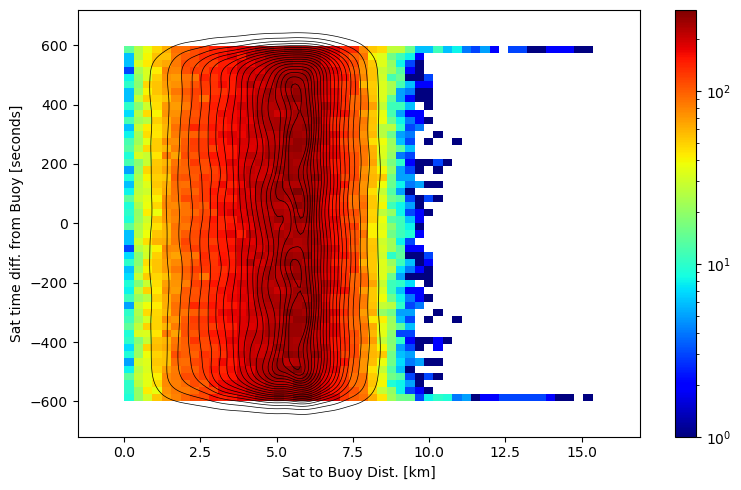

In [11]:
pdfPlotTest('dist', 'satTimeDiff', 'all', df, nx = 50, ny =50)

In [12]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

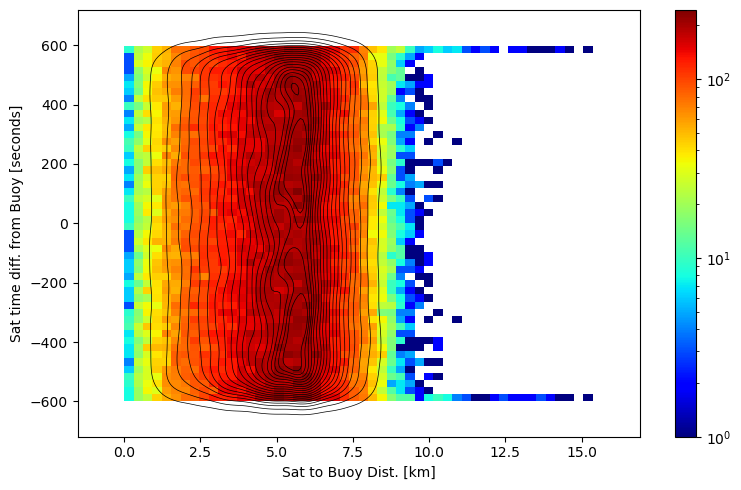

In [13]:
subDF = df.loc[df['label'].isin([1,4,7])]
pdfPlotTest('dist', 'satTimeDiff', 'good', subDF, nx = 50, ny =50)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

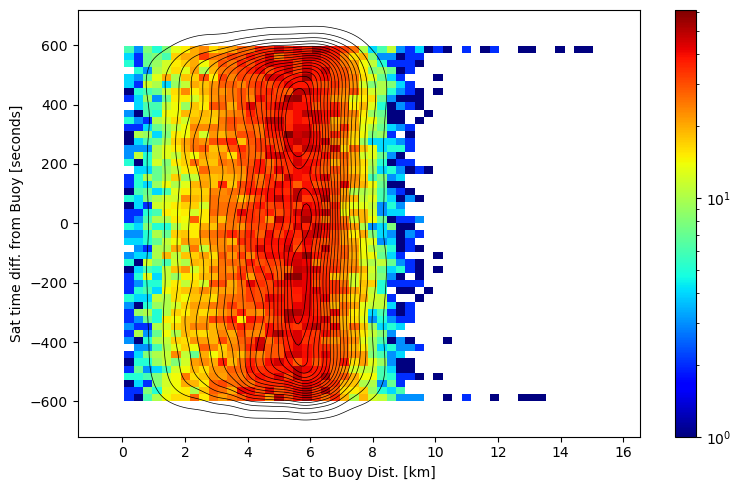

In [14]:
subDF = df.loc[df['label'].isin([0,2,3,5,6,8])]
pdfPlotTest('dist', 'satTimeDiff', 'bad', subDF, nx = 50, ny =50)

In [15]:
def get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', 
                   varName = 'speedDiff', text='', nx = 51, ny = 51,
                  cmapName1 = 'seismic',
                  cmapName2 = 'jet',
                  centerNorm1 = True):
    xvals = subDF[xlabel] 
    yvals = subDF[ylabel]
    varVal = subDF[varName]
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol

    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)

    xx = (x + np.roll(x,-1))/2
    xx = xx[:-1]
    yy = (x + np.roll(x,-1))/2
    yy = yy[:-1]

    print('xmin, xmax', xmin, xmax, x[0], x[-1], xx[0], xx[-1])

    print('ymin, ymax', ymin, ymax, y[0], y[-1], yy[0], yy[-1])

    mean = np.zeros((nx-1, ny-1), dtype=float)* float('nan')
    std = np.zeros((nx-1, ny-1), dtype=float)* float('nan')

    for i in range(nx-1):
        x_subDF = subDF.loc[subDF[xlabel] >= x[i]]
        x_subDF = x_subDF.loc[x_subDF[xlabel] <x[i+1]]
        for j in range(ny-1):
            yx_subDF = x_subDF.loc[x_subDF[ylabel] >= y[j]]
            yx_subDF = yx_subDF.loc[yx_subDF[ylabel] < y[j+1]]

            count = len(yx_subDF)
            if count > 1:
                #print(i,j)
                mean[i,j] = yx_subDF[varName].mean()
                std[i,j] = yx_subDF[varName].std()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    
    cmap = plt.get_cmap(cmapName1).copy()
    cmap.set_bad('k')

    ax = axes[0]
    if centerNorm1:
        pmesh = ax.pcolormesh(x, y, mean.T, cmap=cmap, norm = colors.CenteredNorm())
    else:
        pmesh = ax.pcolormesh(x, y, mean.T, cmap=cmap, vmin=0)
    plt.colorbar(pmesh, ax=ax)
    ax.set_xlabel('Sat to Buoy Dist. [km]')
    ax.set_ylabel('Sat time diff. from Buoy [seconds]')
    ax.set_title(f'mean of {varName}')

    cmap = plt.get_cmap(cmapName2).copy()
    cmap.set_bad('k')

    ax = axes[1]
    pmesh = ax.pcolormesh(x, y, std.T, cmap=cmap, vmin = 0)
    plt.colorbar(pmesh, ax=ax)
    ax.set_xlabel('Sat to Buoy Dist. [km]')
    ax.set_ylabel('Sat time diff. from Buoy [seconds]')
    ax.set_title(f'std. dev of {varName}')

    plt.suptitle(f'For {text} Cluster')

    plt.savefig(f'X_{xlabel}_Y_{ylabel}_var_{varName}_Cluster_{text}.png', dpi = 100)

xmin, xmax -1.3858061506440529 16.006951749673046 -1.3858061506440529 16.006951749673046 -1.2118785716408818 15.833024170669876
ymin, ymax -718.8 718.8 -718.8 718.8 -1.2118785716408818 15.833024170669876


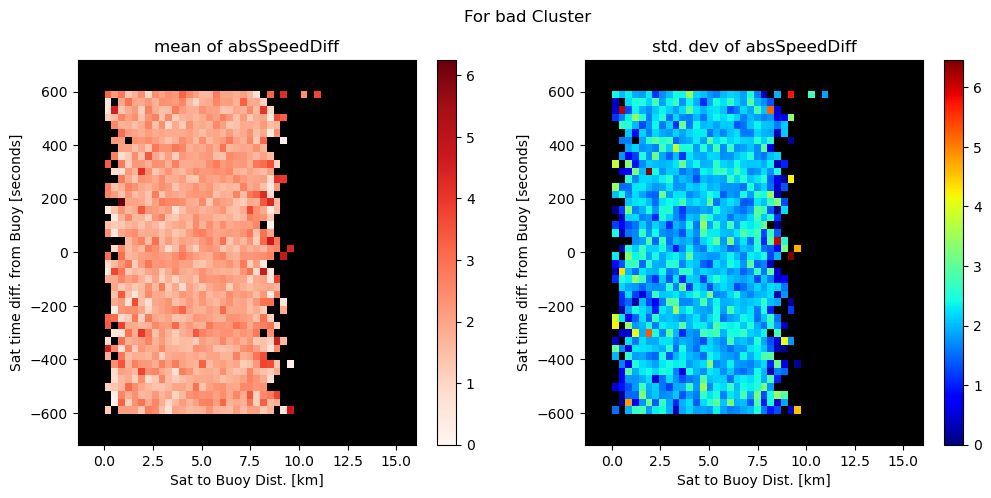

In [153]:
#subDF = df
#subDF = df.loc[df['label'].isin([1,4,7])]
subDF = df.loc[df['label'].isin([0,23,5,6,8])]
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absSpeedDiff', 
               text='bad', 
               centerNorm1 = False, cmapName1 = 'Reds', 
               nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


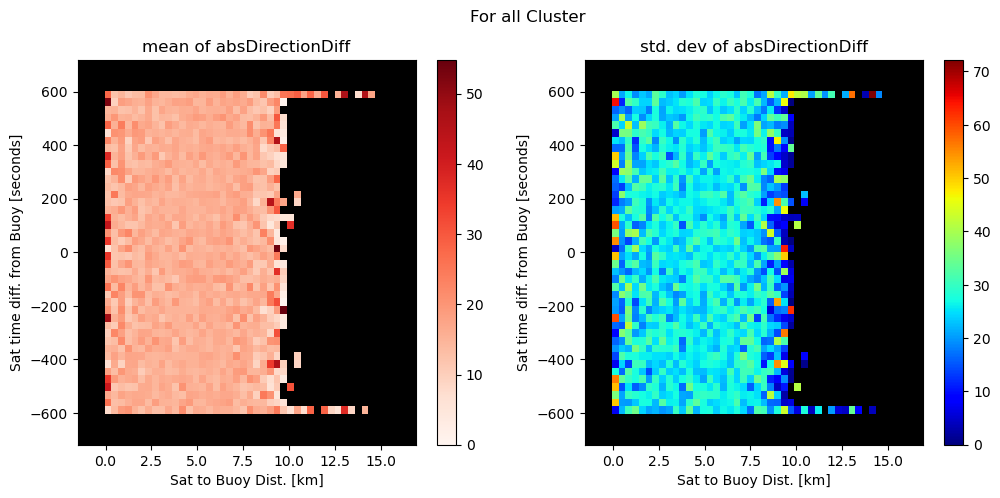

In [165]:
subDF = df
#subDF = df.loc[df['label'].isin([1,4,7])]
#subDF = df.loc[df['label'].isin([0,23,5,6,8])]
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absDirectionDiff', 
               text='all', 
               centerNorm1 = False, cmapName1 = 'Reds', 
               nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


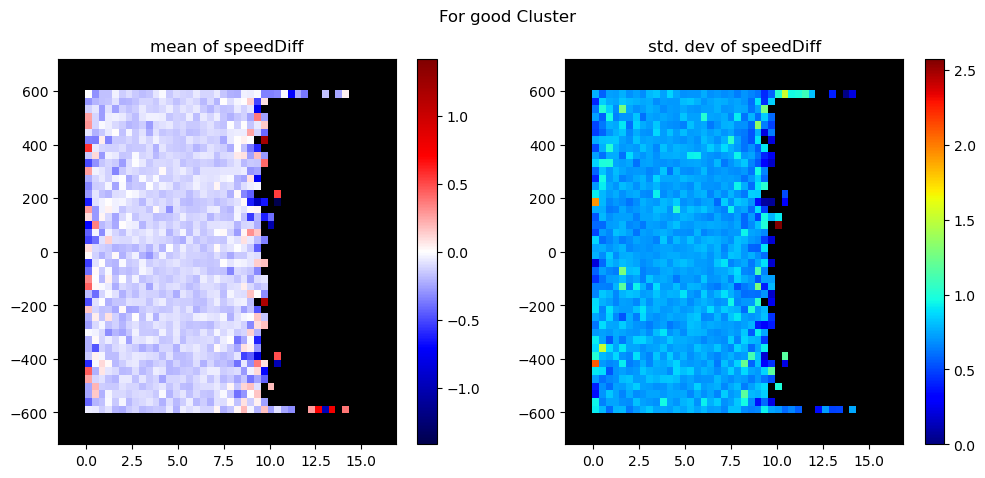

In [127]:
subDF = df.loc[df['label'].isin([1,4,7])]
#subDF = df
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'speedDiff', text='good', nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


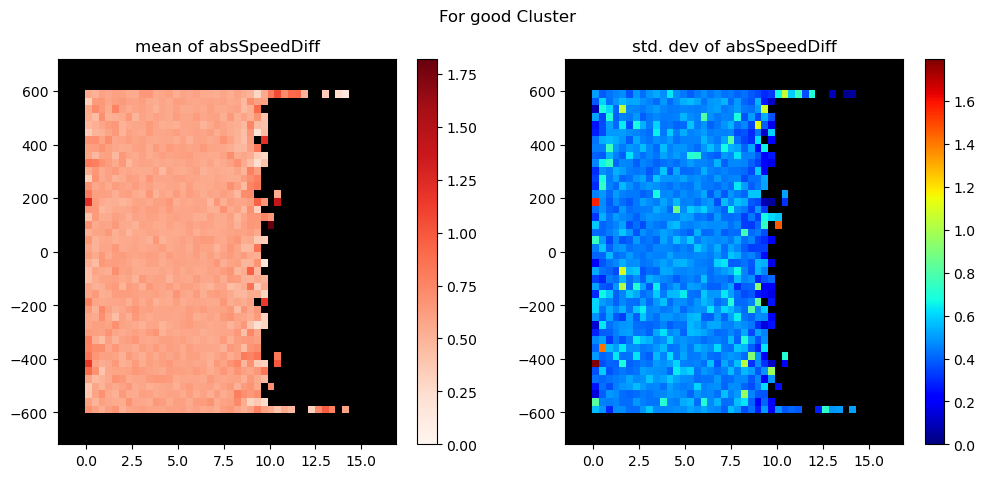

In [136]:
subDF = df.loc[df['label'].isin([1,4,7])]
#subDF = df
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absSpeedDiff', text='good', centerNorm1 = False, cmapName1 = 'Reds', nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


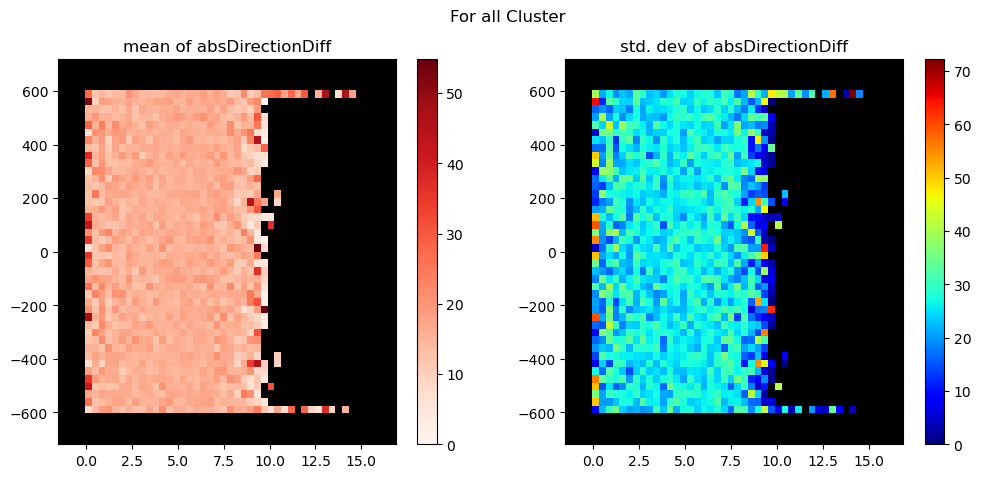

In [137]:
#subDF = df.loc[df['label'].isin([1,4,7])]
subDF = df
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absDirectionDiff', text='all', centerNorm1 = False, cmapName1 = 'Reds', nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


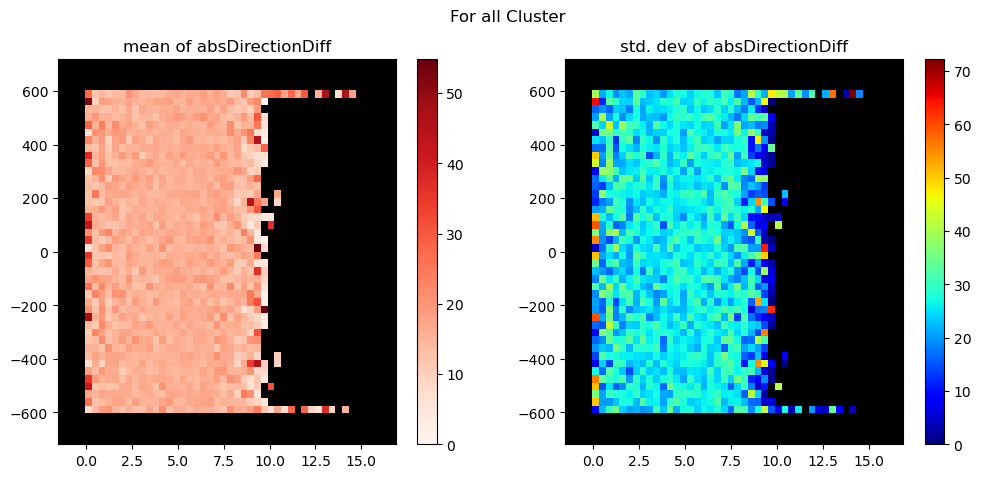

In [144]:
subDF = df
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absDirectionDiff', 
               text='all', 
               centerNorm1 = False, cmapName1 = 'Reds', 
               nx = 51, ny = 51)

xmin, xmax -1.5245871786206255 16.895787089333545 -1.5245871786206255 16.895787089333545 -1.3403834359410838 16.711583346654002
ymin, ymax -718.8 718.8 -718.8 718.8 -1.3403834359410838 16.711583346654002


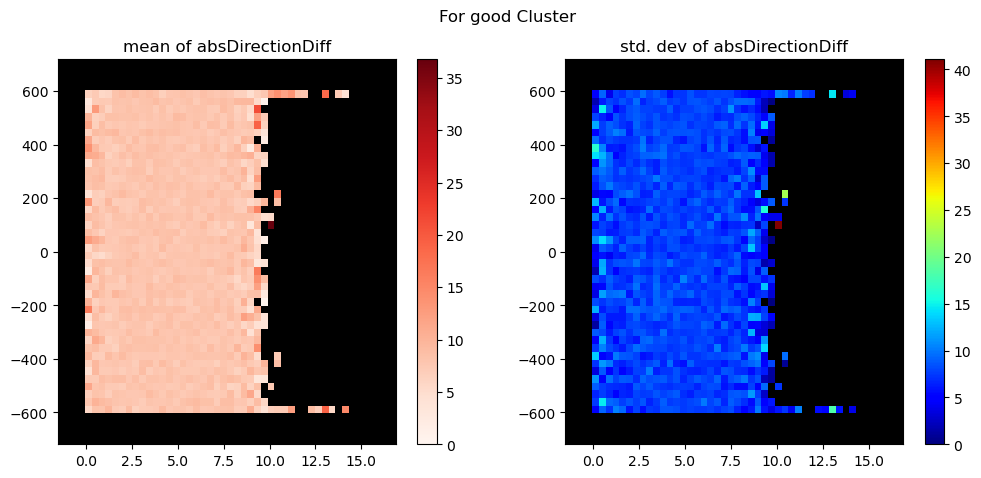

In [142]:
subDF = df.loc[df['label'].isin([1,4,7])]
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absDirectionDiff', 
               text='good', 
               centerNorm1 = False, cmapName1 = 'Reds', 
               nx = 51, ny = 51)

xmin, xmax -1.432779575817011 16.523659426575588 -1.432779575817011 16.523659426575588 -1.2532151857930849 16.34409503655166
ymin, ymax -718.8 718.8 -718.8 718.8 -1.2532151857930849 16.34409503655166


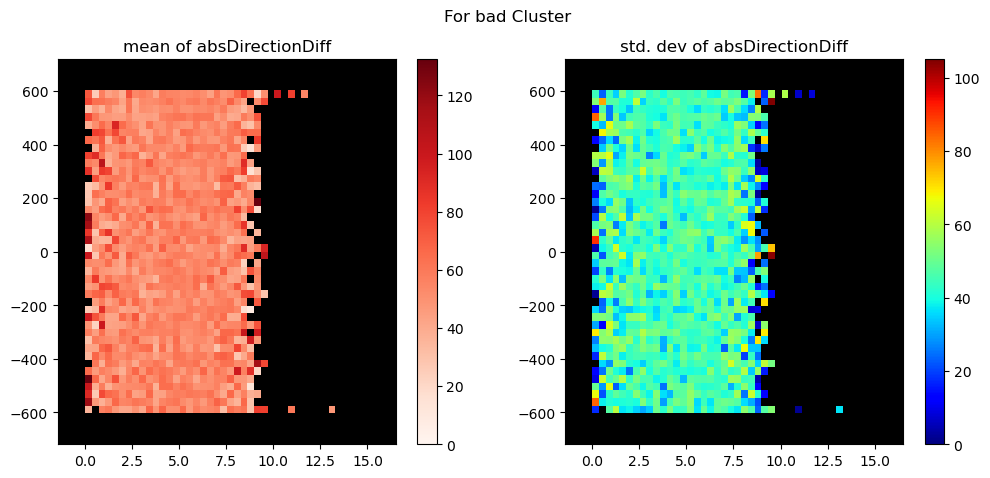

In [143]:
subDF = df.loc[df['label'].isin([0,2,3,5,6,8])]
get_meanAndVar(subDF, xlabel = 'dist', ylabel='satTimeDiff', varName = 'absDirectionDiff', 
               text='bad', 
               centerNorm1 = False, cmapName1 = 'Reds', 
               nx = 51, ny = 51)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


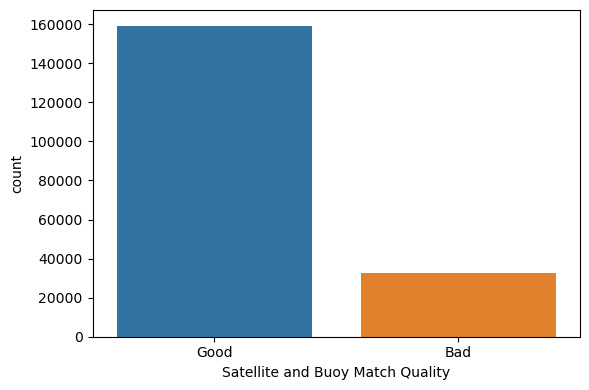

In [194]:
subDF = df
goodBadData = np.empty(len(subDF), dtype=object)
mask = subDF['label'].isin([1,4,7])
goodBadData[mask] = 'Good'
goodBadData[~mask] = 'Bad'

subDF['Satellite and Buoy Match Quality'] = goodBadData

fig, ax = plt.subplots(figsize = (6,4))
sns.countplot(subDF, x = 'Satellite and Buoy Match Quality', ax = ax)
plt.tight_layout()
plt.savefig('Count of good and bad data.png', dpi =100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

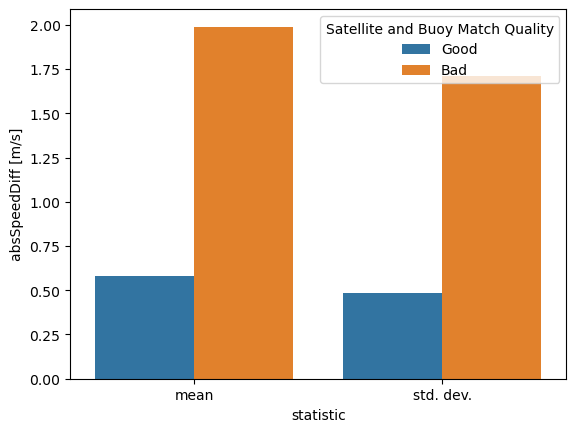

In [220]:
Var = 'absSpeedDiff'
mean = [subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Good'][Var].mean(),
        subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Bad'][Var].mean()]

std = [subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Good'][Var].std(),
        subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Bad'][Var].std()]

statDF = pd.DataFrame({'Satellite and Buoy Match Quality' : ['Good', 'Bad', 'Good', 'Bad'], 
                       'statistic':['mean', 'mean', 'std. dev.', 'std. dev.'], 
                       f'{Var}': mean + std})

sns.barplot(statDF, x='statistic', y= f'{Var}', hue = 'Satellite and Buoy Match Quality')
ax = plt.gca()
ax.set_ylabel(f'{Var} [m/s]')
plt.savefig(f'{Var}_Statistic.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

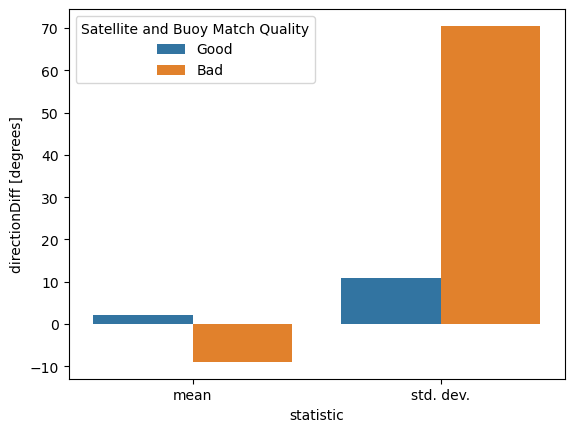

In [224]:
Var = 'directionDiff'
mean = [subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Good'][Var].mean(),
        subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Bad'][Var].mean()]

std = [subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Good'][Var].std(),
        subDF.loc[subDF['Satellite and Buoy Match Quality'] == 'Bad'][Var].std()]

statDF = pd.DataFrame({'Satellite and Buoy Match Quality' : ['Good', 'Bad', 'Good', 'Bad'], 
                       'statistic':['mean', 'mean', 'std. dev.', 'std. dev.'], 
                       f'{Var}': mean + std})

sns.barplot(statDF, x='statistic', y= f'{Var}', hue = 'Satellite and Buoy Match Quality')
ax = plt.gca()
ax.set_ylabel(f'{Var} [degrees]')
plt.savefig(f'{Var}_Statistic.png', dpi=100)

In [222]:
statDF

,Satellite and Buoy Match Quality,statistic,absDirectionDiff
0,Good,mean,8.013053
1,Bad,mean,54.550187
2,Good,std. dev.,7.812882
3,Bad,std. dev.,45.478474
